In [90]:
import torchvision.datasets
import os
import random as r
import torchvision.transforms
import torch.nn.functional as F
import torch
from torchsummary import summary
import torch.nn as nn
import tqdm
from PIL import Image
import cv2
from PIL import ImageDraw
import matplotlib.pyplot as plt

In [12]:
from python_files.get_data import *
from python_files.resnetclass import *

In [14]:
def dataset(path):
    return torchvision.datasets.ImageFolder(
        root=path)

In [15]:
path_buff = '/home/efficientnet/notebooks/af_data/africa_dataset/only_buff'
path_zebra = '/home/efficientnet/notebooks/af_data/africa_dataset/only_zebra'
path_rhino = '/home/efficientnet/notebooks/af_data/africa_dataset/only_rhino'
path_elephant = '/home/efficientnet/notebooks/af_data/africa_dataset/only_elephant'

In [16]:
path_buff_2 = path_buff + '/buffalo/'
path_zebra_2 = path_zebra + '/zebra/'
path_rhino_2 = path_rhino + '/rhino/'
path_elephant_2 = path_elephant + '/elephant/'

In [18]:
#liste_fichiers = os.listdir(path_zebra_2)
#liste_fichiers = os.listdir(path_elephant_2)
#liste_fichiers = os.listdir(path_rhino_2)
liste_fichiers = os.listdir(path_buff_2)
n = 377 ##001 à 377
list_names = []
for i in range(1,10):
    list_names.append('00'+str(i))
for i in range(10, 100):
    list_names.append('0'+str(i))
for i in range(100, 378):
    list_names.append(str(i))
for name in list_names:
    if not((name+'.jpg' in liste_fichiers and name+'.txt' in liste_fichiers)):
        print("probleme", name, (name+'.jpg' in liste_fichiers), (name+'.txt' in liste_fichiers))

probleme 182 False True
probleme 286 False False


In [19]:
def get_detection_dataset(path):
    liste_fichiers = os.listdir(path)
    n_max = max([int(nom[:3]) for nom in liste_fichiers])
    res = []
    for i in range(1, 1+n_max):
        if i<10:
            name_base = '00'+str(i)
        elif i<100:
            name_base = '0'+str(i)
        else:
            name_base = str(i)
            
        if not((name_base+'.jpg' in liste_fichiers and name_base+'.txt' in liste_fichiers)):
            continue 
        else:
            name_im_file = name_base+'.jpg'
            name_txt_file = name_base+'.txt'
            im = Image.open(path + name_im_file)
            rects = []
            with open(path+name_txt_file, "r") as file:
                for line in file.readlines():
                    l = line.split(' ')
                    coords = float(l[1]), float(l[2]), float(l[3]), float(l[4].strip())
                    label = int(l[0])
                    rects.append((label, coords))
        res.append((im, rects))
    return res

In [20]:
det_dataset =get_detection_dataset(path_buff_2) +get_detection_dataset(path_zebra_2)+get_detection_dataset(path_rhino_2)+get_detection_dataset(path_elephant_2)

In [21]:
def interpolate(img, res):
    if img.ndim ==4:
        img_perm = F.interpolate(img, size = res)
        img_perm = img_perm.permute(0,1,3,2)
        img_perm = F.interpolate(img_perm, size =res)
        img_perm = img_perm.permute(0,1,3,2)
        return img_perm
    elif img.ndim==3:
        img_perm = F.interpolate(img, size = res)
        img_perm = img_perm.permute(0,2,1)
        img_perm = F.interpolate(img_perm, size =res)
        img_perm = img_perm.permute(0,2,1)
        return img_perm
    else:
        raise Exception("tensor dimension should be 3 or 4")
    

In [22]:
det_dataset = r.sample(det_dataset, len(det_dataset))

In [23]:
t = torchvision.transforms.ToTensor()
det_data_t = [(interpolate(t(image),140), label) for (image, label) in det_dataset]

In [24]:
resnet = get_resnet(width = 17, resolution=140,depth=[3,3,2,2], num_classes = 4)

In [25]:
path = '/home/efficientnet/notebooks/notebooks/models/resnetaf.txt'

In [26]:
resnet.load_state_dict(torch.load(path,map_location=torch.device('cpu')))

<All keys matched successfully>

# Detection 

In [28]:
def selectivesearch(img):
  """
  SelectiveSearch : 
  - image au format openCV  
  - renvoie une liste de quadruplets (x,y,w,h) représentant les zones de 
    prédiction
  """
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  # Deux modes de détections sont possibles : Fast et Quality
  #ss.switchToSelectiveSearchFast()
  ss.switchToSelectiveSearchQuality()
  return ss.process()

def showrects(img,rects,maxRect=3000):
  """
  showrects : affiche l'image img en y dessinant les rectangles énumérés dans 
  la liste rects.
  """
  # On crée une copie de l'image
  imOut = img.copy()
  # Pour chaque rectangle proposé, si il est dans les 1000 plus probables,
  # on le dessine sur l'image
  for i,rect in enumerate(rects):
      if (i < maxRect):
          x, y, w, h = rect
          cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)
  plt.imshow(imOut)

def filter_rects(rects, min_size=30, max_size = 400):
  """ 
  filter_rects: prend en argument une liste de rectangles et renvoie une liste contenant uniquement
  ceux dont les côtés sont de taille comprise entre min_size et max_size.
  """
  new_list = []

  for rect in rects:
    _,_,w,h = rect 
    if w >= min_size and w <= max_size and h >= min_size and h <= max_size :
      new_list.append(rect)
  return new_list

In [29]:
# transformation de l'image au format 224x224 attendu
# par le modèle
resize = transforms.Compose([
                                 transforms.ToPILImage(),
                                 transforms.Resize(140),
                             transforms.CenterCrop(140)
])
# normalisation attendue par le modèle
transform = transforms.Compose([
      resize, 
      transforms.ToTensor()
])
# test de la transformation sur une image exemple.
#image1 =transform(image1)

In [30]:
def get_labeled_boxes(img,maxRect=2000,threshold=.5,iou=0.5):
  """ 
  get_labeled_boxes : prend en argument
    - une image (img),
    - un nombre maximum de zones de prédictions à tester (maxRect),
    - un seuil d'acceptation d'une zone de prédiction (threshold)
    - un iou
  """
  predictions = []
  rects = selectivesearch(img)
  rects = filter_rects(rects)
  m = min(maxRect, len(rects))
  for i in tqdm.notebook.tqdm(range(m)):
    # crop l'image avec rects[i]
    (x,y,w,h) = rects[i]
    img_rect = img[y:y+h,x:x+w]
    # on transforme l'image d'abord et on la resize 
    img_rect = transform(img_rect)
    img_rect= img_rect.resize(1,3,140,140)


    res_clf = resnet(img_rect)

    ## on convertit en probas avec softmax
    probs = torch.nn.functional.softmax(res_clf)
    proba_max, ind  = torch.max(probs), torch.argmax(probs)

    if proba_max > threshold:
      # on conserve cette prédiction
      triplet = rects[i], int(ind), float(proba_max)
      predictions.append(triplet)

  return predictions 

In [31]:
#preds = get_labeled_boxes(image1,maxRect=2000,threshold=.9,iou=0.7)

In [32]:
#labels = {0 : "buffalo", 1 : "zebra", 2:'rhino', 3:'elephant'}


def show_objs(img,labeled_regions):
  """ 
  - img : image
  - labeled_regions : triplets (rect,label,score) :
    - rect : quadruplet (x,y,w,h)
    - label : un entier entre 0 et 1000
    - score : un flottant entre 0 et 1
  """
  imOut = img.copy()
  
  for rect,label,score in labeled_regions:
      x, y, w, h = rect
      cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 0, 255), 1, cv2.LINE_AA)
      cv2.putText(imOut, "{} : {:.2f}".format(labels[label],score), (x,y+10),
                  cv2.FONT_HERSHEY_SIMPLEX,.6,(0,255,255),2,cv2.LINE_AA)
    
  plt.imshow(imOut)

In [33]:
#show_objs(image1, preds[:10])

In [34]:
def IoU(rect1,rect2):
  """ 
  Renvoie un float avec le IoU entre rect1 et rect2 :
  rect1, rect2 : quadruplets (x,y,w,h) 
  """
  x1,y1,w1,h1 = rect1
  x2,y2,w2,h2 = rect2
  xA,yA = max(x1,x2),max(y1,y2)
  xB,yB = min(x1+w1,x2+w2),min(y1+h1,y2+h2)
  inter = max(0,xB - xA)*max(0,yB-yA)
  union = w1*h1 + w2*h2 - inter
  return inter/union

In [35]:
def get_labeled_boxes2(img,maxRect=2000,threshold=.99,iou=0.2):
  """ 
  get_labeled_boxes : prend en argument
    - une image (img),
    - un nombre maximum de zones de prédictions à tester (maxRect),
    - un seuil d'acceptation d'une zone de prédiction (threshold)
    - un iou
  """
  predictions = []
  rects = selectivesearch(img)
  rects = filter_rects(rects)
  m = min(maxRect, len(rects))
  for i in tqdm.notebook.tqdm(range(m)):
    # crop l'image avec rects[i]
    (x,y,w,h) = rects[i]
    img_rect = img[y:y+h,x:x+w]
    # on transforme l'image d'abord et on la resize 
    img_rect = transform(img_rect)
    img_rect= img_rect.resize(1,3,140,140)
    res_clf = resnet(img_rect)
    ## on convertit en probas avec softmax
    probs = torch.nn.functional.softmax(res_clf)
    proba_max, ind  = torch.max(probs), torch.argmax(probs)
    if proba_max > threshold:
      # on conserve cette prédiction
      triplet = rects[i], int(ind), float(proba_max)

      #on va chercher dans les prédiction déja faites 

      ajouter = True 
      for tpt in predictions:
        rct, idx, _ = tpt
        if idx==int(ind) and IoU(rct, rects[i]) > iou:
          # on a deja détecté ce rectagle
          ajouter = False
      if ajouter :
        predictions.append(triplet) 

  return predictions 

In [36]:
#labeled_regions2 = get_labeled_boxes2(image1)

# RCNN

In [37]:
class Rcnn(nn.Module):
    def __init__(self, resnet, num_classes):
        super(Rcnn, self).__init__()
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.cnn = resnet.layers
        self.num_classes = num_classes
        # recup la taille de la feature map
        r,d,w = resnet.resolution,resnet.depth,resnet.width
        w_actu,r_actu = w,r
        for nb in resnet.depth:
            w_actu*=2
            r_actu=roundsp(r_actu)
        # taille de la feature map : w_actu@r_actu*r_actu
        out_size = int(w_actu*r_actu*r_actu)
        #print(out_size)
        self.classifier = nn.Linear(out_size, num_classes+1)
        self.bboxreg = nn.Linear(out_size, 4)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.cnn(out)
        out = out.view(out.size(0), -1)
        
        clf = self.classifier(out)
        
        bbox = self.bboxreg(out)
        bbox = F.sigmoid(bbox) ## les 4 nombres seront entre 0 et 1
        return clf, bbox


In [38]:
def rcnn(resnet, num_classes, bn1_dict, conv1_dict, cnn_dict):
    """ renvoie un rcnn avec cnn loadé et bloqué"""
    model = Rcnn(resnet, num_classes)
    model.bn1.load_state_dict(bn1_dict)
    model.conv1.load_state_dict(conv1_dict)
    model.cnn.load_state_dict(cnn_dict)
    
    for p in model.bn1.parameters():
        p.requires_grad=False
    for p in model.conv1.parameters():
        p.requires_grad=False
    for p in model.cnn.parameters():
        p.requires_grad=False
    return model
        
    

In [39]:
def get_state_dicts(resnet):
    return resnet.bn1.state_dict(), resnet.conv1.state_dict(), resnet.layers.state_dict()

In [40]:
b,c,cnn= get_state_dicts(resnet)

In [41]:
rcnn_model = rcnn(resnet, 4, b,c,cnn)

In [42]:
#summary(rcnn_model.to('cuda'), (3,140,140))

In [43]:
# reste à définir la loss et le bon dataset

In [44]:
def iou_yolo(rect1, rect2, glob_im):
    _,W,H = glob_im.size()
    x1, y1, w1, h1 = rect1 
    x2, y2, w2, h2 = rect2
    xa = x1 - w1/2
    xb = x2 - w2/2
    ya = y1 - h1/2
    yb = y2 - h2/2
    ha, hb = h1*H, h2*H
    wa, wb = w1*W, w2*W
    ra = [xa, ya, wa, ha]
    rb = [xb, yb, wb, hb]
    return IoU(ra,rb)
    
    
    

In [45]:
def is_positive(region, list_rec_lab, glob_im):
    res = False
    for _, rec in list_rec_lab:
        i = iou_yolo(region, rec, glob_im)
        if i>.5:
            res=True
            region_pos = rec
            return res, rec
    return False

In [46]:
def sample_regions(img, list_rec_lab, region_prop):
    #print(region_prop)
    res = []
    n_pos, n_neg = 0, 0
    for region in region_prop:
        isp = is_positive(region, list_rec_lab, img)
        if isp==False and n_neg<96:
            res.append((region, list_rec_lab[0][0]))
        elif type(isp)==tuple:
            _, rec = isp
            res.append((region, list_rec_lab[0][0], rec))
    return res

In [47]:
def crop_tensor(image, region):
    x,y,w_r,h_r = region
    _,w,h = image.size()
    x_abs ,y_abs = w*x ,h*y
    y_top = y_abs - h_r*h/2
    x_left = x_abs - w_r*w/2
    return image[:, int(x_left):int(x_left+w_r*w), int(y_top):int(y_top+h_r*h)]

In [70]:
def crop_tensor2(image,region):
    x,y,w_r,h_r = region
    _,w,h = image.size()
    x_abs ,y_abs = w*x ,h*y
    y_top = y_abs - h_r*h/2
    x_left = x_abs - w_r*w/2
    return image[:, int(y_top):int(y_top+h_r*h),int(x_left):int(x_left+w_r*w)]

In [71]:
def get_regions(img_t):
    #tr = torchvision.transforms.ToPILImage()
    img_pil = img_t.permute(1,2,0).numpy()
    _,W,H = img_t.size()
    rects = selectivesearch(img_pil)
    res = []
    for rect in rects:
        x,y,w,h = rect
        x_c = (x + w/2)/W
        y_c = (y + h/2)/H
        w_r = w/W
        h_r = h/H
        res.append((x_c, y_c, w_r, h_r))
    return res

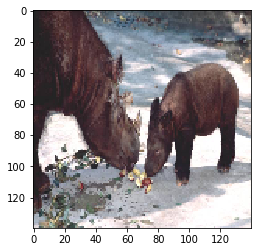

In [76]:
image, grl = det_data_t[77]
plt.imshow(image.permute(1,2,0))

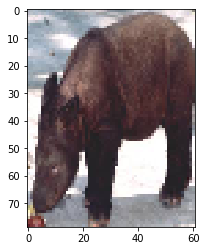

In [78]:
region=grl[1][1] 
im_propo = crop_tensor2(image, region)
plt.imshow(im_propo.permute(1,2,0))

In [84]:
def train_rcnn(model, optimizer, ds_detect_t, n_epoch = 40):
    loss_clf = torch.nn.CrossEntropyLoss()
    loss_reg = torch.nn.SmoothL1Loss()
    for _ in tqdm.notebook.tqdm(range(n_epoch)):
        for data in tqdm.notebook.tqdm(ds_detect_t):
            optimizer.zero_grad()
            image, list_rect_lab = data
            region_prop = get_regions(image)
            #print(len(region_prop))
            regions = sample_regions(image, list_rect_lab, region_prop)
            for reg in regions:
                if len(reg)==2:
                    # region negative 
                    region, label = reg
                    ipt_net = crop_tensor(image, region)
                    ipt_net = interpolate(ipt_net, 140)
                    ipt_net = ipt_net.resize(1, 3, 140, 140)
                    #return ipt_net
                    ipt_net = ipt_net.to('cuda')
                    clf, bbox = model(ipt_net)
                    loss = loss_clf(clf, torch.tensor([4]).to('cuda'))
                    loss.backward()
                else:
                    # region positive
                    region, label, gt_rect = reg
                    ipt_net = crop_tensor(image, region)
                    ipt_net = interpolate(ipt_net, 140)
                    ipt_net = ipt_net.resize(1, 3, 140, 140)
                    ipt_net = ipt_net.to('cuda')
                    #return ipt_net
                    
                    clf, bbox = model(ipt_net)
                    #print(gt_rect)
                    loss = loss_reg(bbox, torch.tensor(gt_rect).to('cuda')) + loss_clf(clf, torch.tensor([label]).to('cuda'))
                    loss.backward()      
            optimizer.step()
    return model

In [86]:
len(det_data_t)

1501

In [314]:
rcnn_model.to('cuda')
opt = torch.optim.Adam(rcnn_model.parameters())
rcnn_model = train_rcnn(rcnn_model, opt, det_data_t[:500], n_epoch = 30)


In [402]:
def get_predictions(model, image, iou=.2):
    model = model.eval()
    region_prop = get_regions(image)
    res = []
    for reg in region_prop:
        ipt_net = crop_tensor(image, reg)
        ipt_net = interpolate(ipt_net, 140)
        ipt_net = ipt_net.resize(1, 3, 140, 140)
        ipt_net = ipt_net.to('cuda')
        clf, bbox = model(ipt_net)
        #return bbox
        probas = F.softmax(clf)
        label = torch.argmax(probas)
        max_prob = torch.max(probas)
        
        if label!= 4:
            ## alors c'est une vraie box
            rectangle = bbox[0][0], bbox[0][1], bbox[0][2], bbox[0][3]
            ajouter = True 
            for tpt in res:
                lbl,prb,rect = tpt
                if int(lbl)==int(label) and iou_yolo(rect, reg, image) > iou:
                      # on a deja détecté ce rectagle
                    ajouter = False
            if ajouter :
                res.append((label.data,max_prob.data, reg))
                
                
                
    return res


In [390]:
dict_labels = {0:'buffalo', 1 : "elephant", 2: "rhino", 3 : "zebra", 4:"background"}

/anaconda/envs/py37_pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


<class 'PIL.Image.Image'>


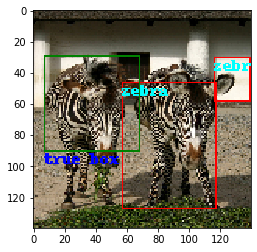

In [431]:
plot_corrections(det_data_t, 189)

In [408]:
def plot_corrections(dataset,n):
    image = dataset[n][0]
    vrai_rect =  dataset[n][1][0][1]
    
    preds=get_predictions(rcnn_model, image)
    t = torchvision.transforms.ToPILImage()
    _, W, H = image.size()
    imagepil = t(image)
    print(type(imagepil))
    predictions = []
    for label, max_prob, box in preds : 
        x,y,w,h = box
        rect =(x-w/2)*W, (y-h/2)*H, w*W, h*H
        if max_prob>0.6:
            predictions.append((rect,label, max_prob))
    #print(predictions)
    imOut = imagepil
    #plt.imshow(imOut)
    #image PIL
    img1 = ImageDraw.Draw(imOut)  
    
    xv,yv,wv,hv = vrai_rect
    xp,yp,wp,hp = (xv-wv/2)*W, (yv-hv/2)*H, wv*W, hv*H
    
    #type(imOut)
    for rect,label,score in predictions:
        x, y, w, h = rect
        x,y,w,h = int(x), int(y), int(w), int(h) 
        #print(x,y,w,h)
        
        shape = [(x,y), (x+w, y+h)]
        img1.rectangle(shape, outline ="red")
        img1.text((x,y), dict_labels[int(label)], fill=(0,255,255,255))
        
    shapev = [(xp,yp), (xp+wp,yp+wp )]
    img1.rectangle(shapev, outline = 'green')
    img1.text((xp,yp+wp ), "true box", fill=(0,0,255,255) )
        #print(dict_labels[int(label)])
        
    plt.imshow(imOut)
    

In [321]:
def plot_predictions(preds,image):
    t = torchvision.transforms.ToPILImage()
    _, W, H = image.size()
    imagepil = t(image)
    print(type(imagepil))
    predictions = []
    for label, max_prob, box in preds : 
        x,y,w,h = box
        rect =(x-w/2)*W, (y-h/2)*H, w*W, h*H
        if max_prob>0.6:
            predictions.append((rect,label, max_prob))
    #print(predictions)
    show_preds(imagepil, predictions)
        
        

In [272]:
def show_preds(img,labeled_regions):
    imOut = img
    #plt.imshow(imOut)
    #image PIL
    img1 = ImageDraw.Draw(imOut)  
    
    
    #type(imOut)
    for rect,label,score in labeled_regions:
        x, y, w, h = rect
        x,y,w,h = int(x), int(y), int(w), int(h) 
        #print(x,y,w,h)
        
        shape = [(x,y), (x+w, y+h)]
        img1.rectangle(shape, outline ="red")
        img1.text((x,y), dict_labels[int(label)], fill=(0,255,255,255))
        #print(dict_labels[int(label)])
        
    plt.imshow(imOut)